## Quick Start

In [15]:
import py0
import matplotlib.pyplot as plt
import numpy as np
import maxent

### Setting-up an SEAIR Model
Susceptible (${\bf S}$) individuals can get exposed (${\bf E}$) to the disease through I-S and A-S contacts with infectivity rates $\beta$ and $\beta'$. Once exposed, they become asymptomatic (${\bf A}$) or infected (${\bf I}$) at rates $\alpha$ or $\gamma$. They finally recover or die at rate $\mu$ and become resolved (${\bf R}$).
<img src='img/SEAIR.png' width="300">

In [5]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
# defining a fully connected mobility matrix
dense_mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
dense_mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(dense_mobility_matrix, dense_mobility_matrix_diag)
dense_mobility_matrix_norm = dense_mobility_matrix / np.sum(dense_mobility_matrix, axis=1, keepdims=True)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)

Let's make a 10-node contact network with node connection probability of 0.4. The infection starts in node 1 with a single individual exposed.

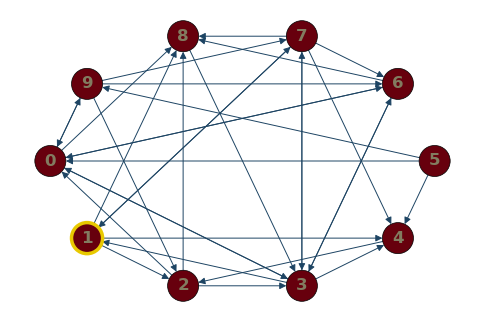

In [8]:
M=10
p = 0.4
true_node = 1
graph = py0.gen_random_graph(M,p, seed=0)
py0.draw_graph(graph, dpi =100, true_origin=true_node, heatmap=True, color_bar=False)

Defining diesease parameters:

Plotting 10 patches in a 3 x 4 grid


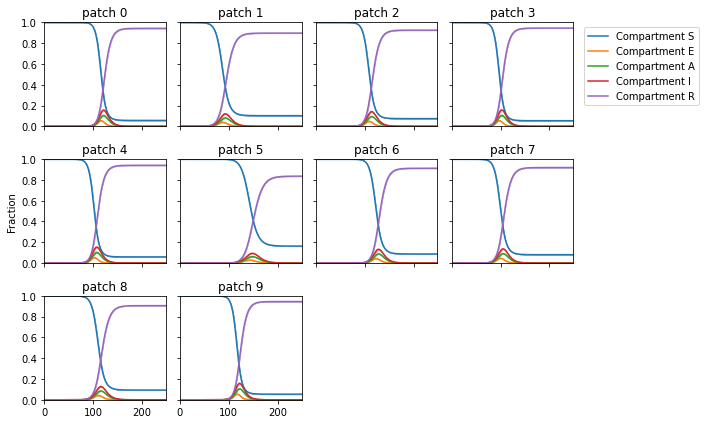

In [11]:
beta_A = 0.025
beta_I=0.05
alpha =1/3
gamma=1/2
mu=1/7
M=10
C=4
timesteps=250
# sparsify mobility matrix for sparse graphs
sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, dense_mobility_matrix)
tmat = py0.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 1/alpha, 0) # calling this alpha
tmat.add_transition('E', 'I', 1/gamma, 0) # calling this gamma
tmat.add_transition('A', 'R',1/mu, 0) # mu
tmat.add_transition('I', 'R', 1/mu, 0) # mu
infect_fxn = py0.contact_infection_func(infections_compartments, area=area)
model = py0.MetaModel(infect_fxn, timesteps, populations=np.array(population))
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# Assume starting from Node true_node
initial_exposed = 1/population[true_node]
start[true_node,0] = initial_exposed
sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
ref_traj = model(sparsed_mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
ref_traj = ref_traj[np.newaxis, ...]
py0.patch_quantile(ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

### Applying MaxEnt 

We need to obtain a set of observations from the reference trajectory. This is done by considering weekly averages from compartments I and R. To account for uncertainty we add 0.05 multiplicative noise and a Laplace prior of 1.

In [12]:
def gen_restraints(ref_traj, prior=None, start=None, end=None):
    if prior:
        prior = maxent.Laplace(1)
    else:
        prior = maxent.EmptyPrior()
    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.05, start_time=start, end_time=end)
    return restraints, plot_fxns_list, restrained_patches

In [16]:
npoints = 5
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)

Restraints are set in this time range: [50, 140]
94 0.04975285 0.05273135913584738
129 0.029316694 0.032077378938796
115 0.113994256 0.11806512630097674
122 0.062029254 0.06911402834944823
101 0.11352191 0.12239990691234638
52 2.673287e-05 2.7549698356717784e-05
101 0.191924 0.2019153297462253
129 0.8771344 0.8756767595708168
73 0.0014521469 0.0014569129521043063
115 0.6488122 0.657434425422003
101 0.15202422 0.13335048824813567
108 0.1295897 0.11855093982687155
129 0.015670275 0.015999471032561663
94 0.0971091 0.09566145227181654
80 0.011050001 0.011195641006993459
94 0.14638475 0.1517370546602452
80 0.012830333 0.01216684885735983
115 0.77781504 0.8043227674350953
122 0.86995727 0.8350106644020316
59 0.0002302867 0.0002223469995590988
115 0.13835825 0.13071822293735383
66 0.00016264888 0.00016307311067676058
59 4.6608624e-05 4.488512328249778e-05
136 0.029640017 0.03192676602524879
108 0.1119285 0.10469312348888637
94 0.026497573 0.026851382651177924
136 0.8581027 0.8422628830391345


Generating an ensemble of trajectories to apply MaxEnt:

In [25]:
def gen_samples(graph, mobility_matrix=dense_mobility_matrix, timesteps =250, area = area, populations = population):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, mobility_matrix)
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 2) # call this alpha
    tmat.add_transition('E', 'I', 2, 2) # call this gamma
    tmat.add_transition('A', 'R',6, 2) # mu
    tmat.add_transition('I', 'R', 6, 2)
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 1e-7
    start_logits = np.zeros((M))
    param_model = py0.MetaParameterJoint(start_logits, sparsed_mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = py0.contact_infection_func(infections_compartments, area = area)
    model = py0.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    return trajs
trajs = gen_samples(graph, timesteps =250, area = area, populations = population)
prior_exposed_patch = py0.exposed_finder(trajs)

100%|██████████| 16/16 [00:32<00:00,  2.01s/it]


Applying MaxEnt:

In [28]:
from keras.callbacks import ReduceLROnPlateau
def maxent_fit(trajs, restraints):
    me_model = maxent.MaxentModel(restraints)
    from tensorflow import keras
    optimizer=keras.optimizers.Adam(lr=1e-2) 
    me_model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=10, min_lr=0)
    me_history = me_model.fit(trajs, batch_size=trajs.shape[0], epochs=200, callbacks=[reduce_lr], verbose=0)
    return me_model
me_model = maxent_fit(trajs, restraints)

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [40]:
def compare_patches(ref_traj, trajs, weights_dict, method, restrained_patches, plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                py0.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                py0.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                py0.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('C0')
                ax[i,j].spines['top'].set_color('C0') 
                ax[i,j].spines['right'].set_color('C0')
                ax[i,j].spines['left'].set_color('C0')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
            if i==2:
                ax[i,j].set_xlabel('Time (days)')
    plt.tight_layout()

Let's have a look at the posterior trajectory. The dashed lines are the reference trajectory and the red markers are observation data points coming from patches with blue highlighted edges.

Plotting 10 patches in a 3 x 4 grid


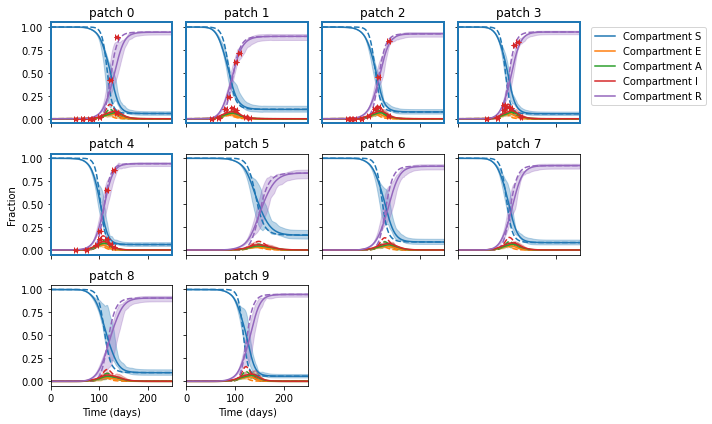

In [41]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)
plt.tight_layout()

Finally, we can have a look at model's patient-zero origin inference:

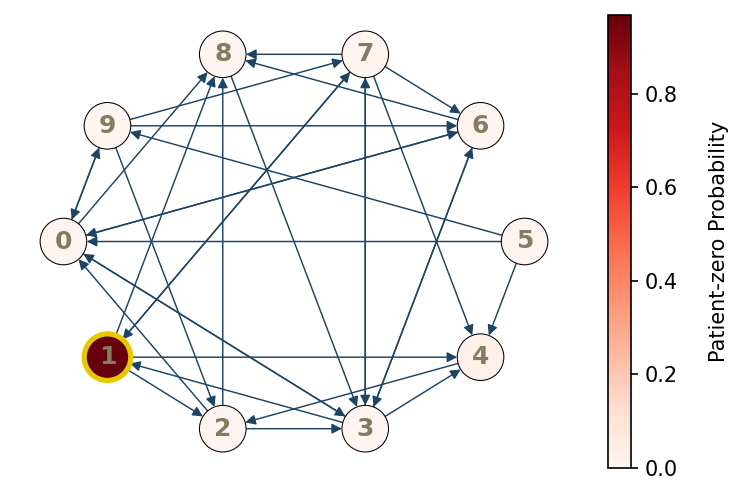

In [42]:
me_w = me_model.traj_weights
exposed_prob = py0.weighted_exposed_prob_finder(
                            prior_exposed_patch, M)
weighted_exposed_prob = py0.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=me_w)
py0.draw_graph(graph, weights=weighted_exposed_prob, heatmap=True, true_origin=true_node)